# Capstone Project Part 6: Transforming Text

**Authur:** Kate Meredith 

**Date:** September-November 2022

**Notebook #**: 6 of

## Background

**Source:** Data was collected from [CoffeeReview.com](https://www.coffeereview.com/). See prior notebooks for details on scraping, cleaning and compilation. This notebook focuses on tokenizing the review text.

**Goal:** Experiment with text tokenizing methods to compare baseline effectiveness across the tested tools.

## References

- Used this [article](https://stackoverflow.com/questions/37080612/pandas-dataframe-filter-regex) for searching for specific text in columns
- Used BrainStation notebook on working with text
- Referenced this [article](https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b) for strategy on how to stratefy train/val/test split where target is a continuous variable
- Referenced this [article](https://stackoverflow.com/questions/61158963/how-to-sort-the-result-by-pandas-value-counts) to see value_counts sorted by column value instead of frequency
- Natural Language Toolkit (NLTK): Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.

In [ ]:
#Importing libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import operator

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp
from scipy.spatial.distance import cosine as cosine_distance
from gensim.utils import simple_preprocess
from sklearn.ensemble import RandomForestRegressor

### Importing and previewing data

In [ ]:
coffee = pd.read_csv('coffee.csv')

In [ ]:
coffee.info()

In [ ]:
coffee.shape

In [ ]:
coffee.head()

In [ ]:
coffee.describe()

## Preprocessing

Before we create our X and y, there are some repeated words that appear in the `p1`, `p2`, and `p3` paragraphs as headers. In most reviews, these paragrapsh correspond to:

- p1: Blind Assessment
- p2: Notes
- p3: The Bottom Line OR Who Should Drink it

We'll first check to see if these paragraphs do contain the information we expect.

Checking the composition of paragraphs:

In [ ]:
#see how many of p1 paragraphs reference which type of information
len(coffee.loc[coffee['p1'].str.contains(r'(Blind Assessment).*')])

In [ ]:
#see how many of p2 paragraphs reference which type of information
len(coffee.loc[coffee['p2'].str.contains(r'(Notes).*')])

In [ ]:
#see how many of p3 paragraphs reference which type of information
len(coffee.loc[coffee['p3'].str.contains(r'(The Bottom).*')])

In [ ]:
#see how many of p3 paragraphs reference which type of information
len(coffee.loc[coffee['p3'].str.contains(r'(Who Should).*')])

As expected, paragraphs 1 and 2 contain consistent data, and paragraph 3 is split. We'll remove "Blind Assessment", "The Bottom Line", "Who Should Drink it" and "Notes" from our bag of words as they appear in every review and therefore won't be useful in distinguishing content.

Getting rid of repeat words:

In [ ]:
#splitting out paragraph review score labels
coffee[['ba','p1']] = coffee['p1'].str.split(":", n=1, expand=True)

In [ ]:
#splitting out paragraph review score labels
coffee[['N','p2']] = coffee['p2'].str.split(":", n=1, expand=True)

In [ ]:
#splitting out paragraph review score labels
coffee[['tbl','p3']] = coffee['p3'].str.split(":", n=1, expand=True)

In [ ]:
#drop unneeded holding columns
coffee.drop(['ba', 'N', 'tbl'], axis=1, inplace=True)

In [ ]:
#checking for nan
coffee.isna().sum()

In [ ]:
#removing headers generated a couple nan rows
#drop rows missing value in overall_score column 
coffee.dropna(subset = ['p3'], inplace=True)

In [ ]:
len(coffee)

### Stratifying Data

Given that we can't simply stratefy our train, validation and test splits on a continuous target variable, adding a categorical value corresponding to `overall_score`. This allows train, val, test to be stratefied, allowing for even distribution of values for training, validation and testing. We'll drop our temporary extra y column before running any tests.

We're going to use a bit more robust mapper in this notebook than the last because of how many scores are clustered in the 80 and 90s.

In [ ]:
#plot y distribution
plt.figure()
plt.hist(coffee['overall_score'])
plt.title('historgram of overall_score')
plt.show()

In [ ]:
#creating categorical mapper
score_mapper = {range(0,70):'one', range(70,80):'two', range(80,85):'three', range(85,90):'four', range(90,95):'five', range(95,101): 'six'}

In [ ]:
coffee['overall_cat'] = coffee['overall_score'].replace(score_mapper)

In [ ]:
coffee['overall_cat'].unique()

In [ ]:
#verifying splits appear accurate
coffee[['overall_score', 'overall_cat']].sample(20)

### Creating X and y:

To evaluate how effective the text transformation methods are, we'll create our X and y data.

- y or target = `overall_score`
- X = remaining data, but to tokenize we'll break work with `p1`,`p2`, and `p3` one at a time.

In [380]:
X = coffee.drop(['overall_score', 'overall_cat'], axis = 1)

In [381]:
X.shape

(6554, 18)

In [382]:
y = coffee[['overall_score','overall_cat']]

In [383]:
y.shape

(6554, 2)

Creating train, validation and testing splits:

In [384]:
#create train/test split, using 20% given dataset size

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y['overall_cat'], test_size=0.2)

In [385]:
#create train/validate split, using 20% given dataset size

X_remain, X_val, y_remain, y_val = train_test_split(X_train, y_train, stratify = y_train['overall_cat'], test_size=0.2)

Resetting index on all of these so that they can be recombined later after text is transformed:

In [386]:
#resetting index on X_remain
X_remain.reset_index(drop=True, inplace=True)

In [387]:
#resetting index on X_val
X_val.reset_index(drop=True, inplace=True)

In [388]:
#resetting index on X_test
X_test.reset_index(drop=True, inplace=True)

In [389]:
#resetting index on X_remain
y_remain.reset_index(drop=True, inplace=True)

In [390]:
#resetting index on X_remain
y_val.reset_index(drop=True, inplace=True)

In [391]:
#resetting index on X_remain
y_test.reset_index(drop=True, inplace=True)

Checking reset dfs:

In [392]:
X_remain.head()

,coffee_name,roaster_name,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,p1,p2,p3
0,Guatemala Covadonga Micro-Lot,Klatch Coffee,9,2013,53,69,9,9,8,9,8,34.053691,-118.242766,15.585555,-90.345759,"Smooth, layered complexity. Delicate floral n...",Produced on Finca Covadonga by farmer Roberto...,A fine exemplar of the sweet lucidity of the ...
1,Nano Genji Agaro Gera,Temple Coffee Roasters,6,2020,52,68,9,9,9,9,8,38.581061,-121.493895,10.211670,38.652120,"Deep-toned, fruit-centered, richly aromatic. ...",Ethiopia coffees like this one are produced l...,"A deeply fruit-toned washed Ethiopia cup, bro..."
2,Sumatran Reserve (K-Cup),Green Mountain Coffee,12,2005,54,71,6,6,6,6,6,44.337125,-72.755497,1.636405,99.691038,(As brewed in a Keurig B60 single-serve brewi...,Keurig brewing devices were among the first s...,Lovers of Sumatras who care more about the ma...
3,Port of Call,Island Joe's Coffee,6,2007,39,46,8,7,7,7,7,24.562557,-81.772437,-2.483383,117.890285,"Very sweet-toned aroma with a muted, pungent ...",Joe Wells started his small-batch roasting bu...,Those who prefer a calm port of call.
4,Yemen Mocha Harazi,Dragonfly Coffee Roasters,7,2021,62,78,9,8,9,9,8,36.030113,-114.982619,16.347124,47.891527,"Crisply spice-toned. Molasses, dried cherry, ...",Sourced from producer groups across Yemen’s S...,A sweetly spice-toned Yemen cup with underton...


In [393]:
X_val.head()

,coffee_name,roaster_name,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,p1,p2,p3
0,Ethiopia Yirgacheffe Washed G1,A.R.C.,11,2017,55,76,8,8,9,9,8,22.279328,114.162813,10.211670,38.652120,"Delicate, gently tart, spice-toned. Pomegrana...","Produced in Yirgacheffe, a coffee region in s...",A cup with a fine-tea-like appeal in its subt...
1,Espresso,Lighthouse Roasters,9,2005,36,43,6,8,7,8,8,47.603832,-122.330062,10.198811,-12.161417,For both Ken (81) and co-taster Ted Lingle (7...,Lighthouse Roasters is a one-location cafe an...,Those who enjoy a little burn in the roast.
2,Haitian Bleu,Coffee Masters,7,2007,50,57,8,7,7,7,7,42.443631,-88.236478,19.139995,-72.357097,"Soft aroma, with floral top notes, and prune-...",Haitian Bleu is the trademarked name for a co...,"No aromatic fireworks certainly, but a smooth..."
3,Limu Gomma Ethiopia,PT's Coffee Roasting Co.,6,2008,59,82,8,8,8,8,8,39.049011,-95.677556,10.211670,38.652120,"Very sweet-toned aroma: honey, cherryish coff...",Certified organically grown. PT's Coffee is a...,Those who enjoy light-bodied but crisply auth...
4,El Salvador Santa Elena Honey Pacamara,Temple Coffee and Tea,2,2014,55,68,9,9,8,9,9,38.581061,-121.493895,13.800038,-88.914068,"Sweetly bright, lyric, exhilarating. Honey, p...",This lot is comprised entirely of the much ad...,A classically bright cup enveloped in sweetne...


In [394]:
X_test.head()

,coffee_name,roaster_name,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,p1,p2,p3
0,Kochere Yirgacheffe Ethiopia (Instant Coffee),Tandem Coffee,9,2018,75,75,8,7,7,7,7,43.661028,-70.254860,10.211670,38.652120,Evaluated at proportions of 5 grams of instan...,This coffee tied for the third-highest rating...,"An instant that captures some of the zesty, l..."
1,Medina Natural,JBC Coffee Roasters,8,2021,58,76,9,8,9,9,8,43.074761,-89.383761,15.585555,-90.345759,"Gently fruit-toned, richly bittersweet. Raspb...",Produced at Finca Medina from trees of the Bo...,A pretty natural-processed Guatemala that lea...
2,Kerinci Palompek Sumatra,JBC Coffee Roasters,6,2020,58,78,9,9,9,9,8,43.074761,-89.383761,-2.483383,117.890285,"Deeply aromatic, complex, multi-layered. Star...",Produced by smallholding members of the Koeti...,"Paradoxically sweet and savory, but harmoniou..."
3,Ethiopian Shanta Golba Espresso Fair Trade,JBC Coffee Roasters,5,2012,52,56,9,8,8,8,7,43.074761,-89.383761,10.211670,38.652120,Evaluated as espresso. Deep and sweet in the ...,This coffee is certified organically grown an...,Particularly distinctive and agreeable in sho...
4,Bluekoff Single Origin Thai Espresso Blend (A4...,Bluekoff Company,2,2013,43,55,9,8,9,8,8,13.752494,100.493509,14.897192,100.832730,Evaluated as espresso. Sweet-toned aroma: Ban...,The A in this blends name refers to the grade...,"Impressive straight-shot espresso, with butte..."


In [395]:
y_remain.head()

,overall_score,overall_cat
0,93,five
1,94,five
2,81,three
3,87,four
4,93,five


In [396]:
y_val.head()

,overall_score,overall_cat
0,92,five
1,80,three
2,87,four
3,92,five
4,94,five


In [397]:
y_test.head()

,overall_score,overall_cat
0,86,four
1,93,five
2,94,five
3,90,five
4,93,five


Below, verifying the shape of our new remain, validation and test splits.

In [398]:
X_train.shape

(5243, 18)

In [399]:
X_remain.shape

(4194, 18)

In [400]:
X_val.shape

(1049, 18)

In [401]:
X_test.shape

(1311, 18)

In [402]:
y_train.shape

(5243, 2)

In [403]:
y_remain.shape

(4194, 2)

In [404]:
y_val.shape

(1049, 2)

In [405]:
y_test.shape

(1311, 2)

In [406]:
y_test.head()

,overall_score,overall_cat
0,86,four
1,93,five
2,94,five
3,90,five
4,93,five


Do my train, val, test splits have similar distributions?

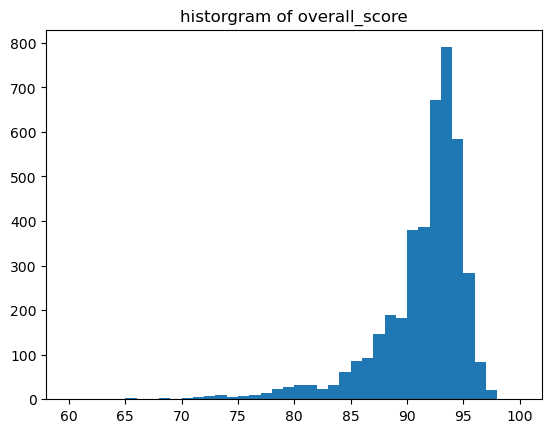

In [407]:
#plot y val distribution
plt.figure()
plt.hist(y_remain['overall_score'], range(60,101))
plt.title('historgram of overall_score')
plt.show()

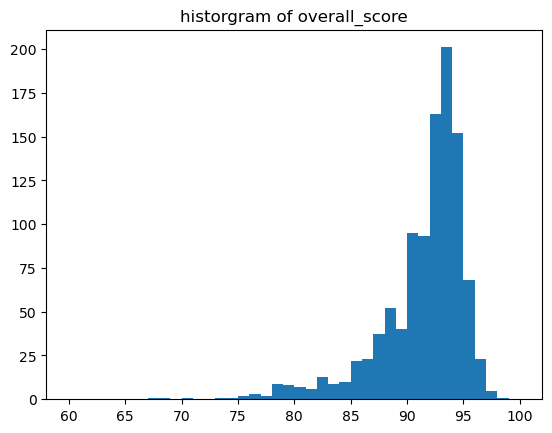

In [408]:
#plot y val distribution
plt.figure()
plt.hist(y_val['overall_score'], range(60,101))
plt.title('historgram of overall_score')
plt.show()

The test group looks a bit different but each group does have the range of values with somewhat similar distributions.

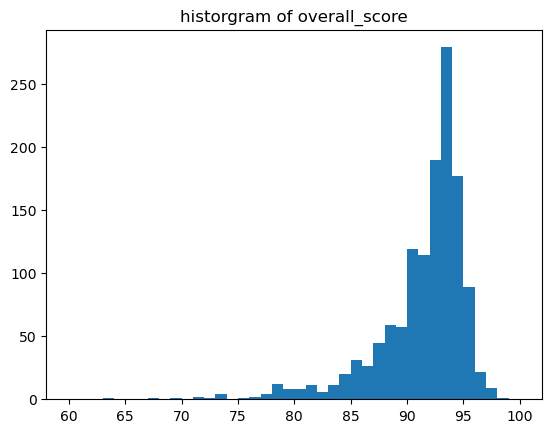

In [409]:
#plot y val distribution
plt.figure()
plt.hist(y_test['overall_score'], range(60,101))
plt.title('historgram of overall_score')
plt.show()

The distributions aren't perfect, but even enough. Now we'll drop the categorical column `overall_cat` so that we are just working with our continous targe `overall_score`.

In [410]:
y_train = y_train['overall_score']

In [411]:
y_remain = y_remain['overall_score']

In [412]:
y_val = y_val['overall_score']

In [413]:
y_test = y_test['overall_score']

Verifying y shapes as expected with categorical version dropped:

In [414]:
y_train.head()

4216    93
6424    84
6401    82
4759    89
3373    92
Name: overall_score, dtype: int64

In [415]:
y_remain.head()

0    93
1    94
2    81
3    87
4    93
Name: overall_score, dtype: int64

In [416]:
y_val.head()

0    92
1    80
2    87
3    92
4    94
Name: overall_score, dtype: int64

In [417]:
y_test.head()

0    86
1    93
2    94
3    90
4    93
Name: overall_score, dtype: int64

## Transforming the Text

Below we'll try a few different text transformation methods. If time allows, we may revisit these and try additional methods to improve transformations.

### Bag of Words with CountVectorizer()

We'll start with CountVectorizer().

Creating bag of words on `p1` and graphing the most popular words:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


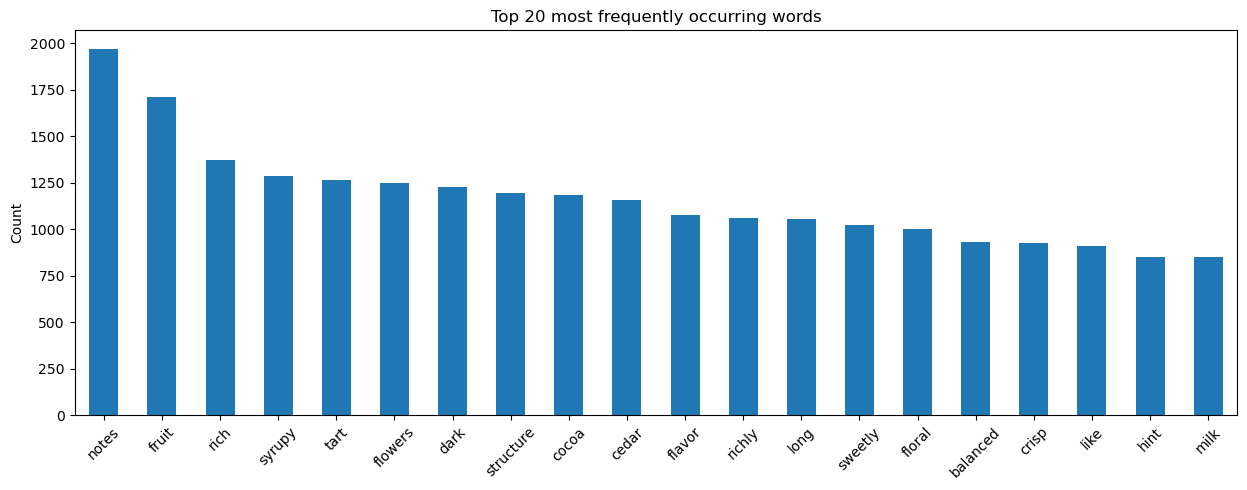

In [418]:
# 1. Instantiate with starting parameters
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=5, max_features=500, max_df=2000)

# 2. Fit 
bagofwords_p1.fit(X_remain["p1"])

# 3. Transform
p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

#the following looks at the 20 most popular words from paragraph 1
word_counts = pd.DataFrame(
    {"counts": p1_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p1.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Looking at the most popular words to see if anything stands out. We might benefit from stemming or lemmatization (see similar words like 'pleasant', 'pleasantly', and 'pleasing'.

In [419]:
bagofwords_p1.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['87',
 '88',
 '89',
 '90',
 '91',
 '92',
 'acid',
 'acidy',
 'admired',
 'aftertaste',
 'agave',
 'almond',
 'amber',
 'amplified',
 'anise',
 'apple',
 'apricot',
 'aromatic',
 'aromatics',
 'astringency',
 'astringent',
 'attractive',
 'authority',
 'b70',
 'backgrounded',
 'baker',
 'baking',
 'balance',
 'balanced',
 'banana',
 'barrel',
 'bean',
 'bergamot',
 'berries',
 'berry',
 'best',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blackberry',
 'blend',
 'blood',
 'blooming',
 'blossom',
 'blueberry',
 'bodied',
 'body',
 'brandy',
 'brazil',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brisk',
 'brittle',
 'brown',
 'buoyant',
 'buoyantly',
 'burned',
 'butter',
 'butterscotch',
 'buttery',
 'cacao',
 'candied',
 'candy',
 'cappuccino',
 'capsule',
 'caramel',
 'caramelly',
 'carbon',
 'cardamom',
 'carob',
 'carried',
 'carries',
 'carry',
 'carrying',
 'cashew',
 'cedar',
 'cedary',
 'centered',
 'centers',
 'character',
 'charred',
 'cherry',
 '

In [420]:
#checking how many words there are
len(bagofwords_p1.get_feature_names())

500

In [421]:
# 1. Instantiate the model
p1_model = LinearRegression()

# 2. Fit the model
p1_model.fit(p1_remain_transform, y_remain)

LinearRegression()

In [422]:
# 3. Scoring the training model
print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.7844193816163427
The R2 score for p1 CountVectorizer validation data is: 0.7338312344946021


Creating bag of words for `p2` with CountVectorizer and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


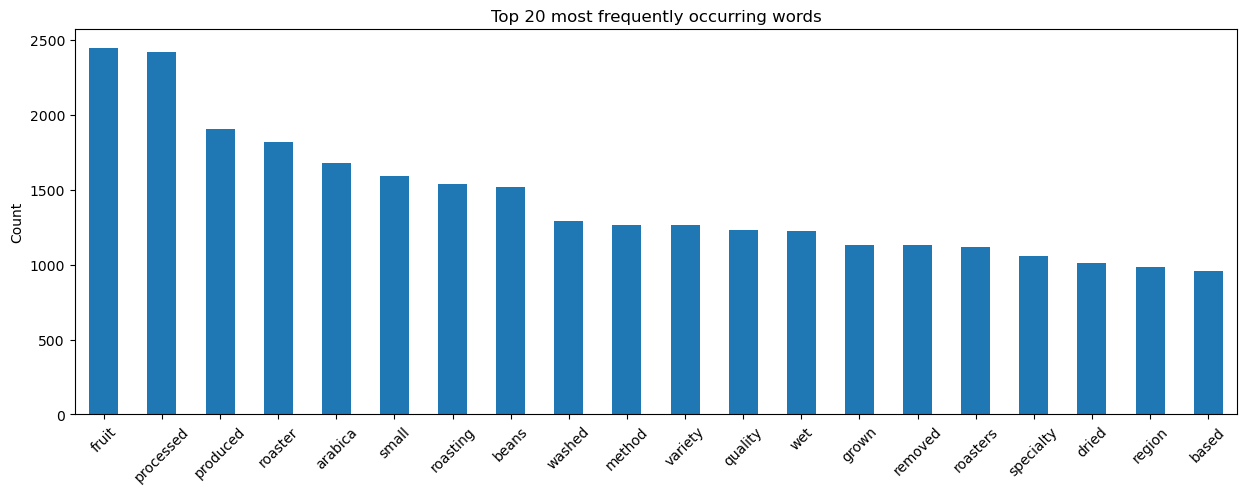

In [423]:
# 1. Instantiate 
bagofwords_p2 = CountVectorizer(stop_words='english', min_df=5, max_features=500, max_df=2000)

# 2. Fit 
bagofwords_p2.fit(X_remain["p2"])

# 3. Transform
p2_remain_transform = bagofwords_p2.transform(X_remain["p2"])
p2_val_transform = bagofwords_p2.transform(X_val["p2"])
p2_test_transform = bagofwords_p2.transform(X_test["p2"])

#the following looks at the 20 most popular words from paragraph 2

word_counts = pd.DataFrame(
    {"counts": p2_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p2.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [424]:
bagofwords_p2.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['0626',
 '100',
 '1282',
 '1990',
 '2005',
 '2007',
 '2010',
 '2012',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '256',
 '30',
 '433',
 '454',
 '4627',
 '5282',
 '608',
 '678',
 '763',
 '800',
 '858',
 '866',
 '877',
 '879',
 '886',
 '888',
 '916',
 'aa',
 'acidity',
 'active',
 'addition',
 'admired',
 'africa',
 'agricultural',
 'air',
 'allowed',
 'america',
 'american',
 'anaerobic',
 'angeles',
 'approach',
 'arabica',
 'area',
 'aroma',
 'aromatic',
 'artisan',
 'asia',
 'associated',
 'auction',
 'available',
 'award',
 'awarded',
 'bag',
 'barista',
 'based',
 'batch',
 'batches',
 'bay',
 'bean',
 'beaned',
 'beans',
 'best',
 'better',
 'big',
 'bird',
 'black',
 'blend',
 'blends',
 'bold',
 'botanical',
 'bourbon',
 'boutique',
 'brand',
 'brazil',
 'brew',
 'brewing',
 'bring',
 'brothers',
 'burundi',
 'business',
 'cafe',
 'café',
 'california',
 'called',
 'capsule',
 'case',
 'catuai',
 'caturra',
 'celebrated',
 'central',
 'certified',
 'chain',
 'character',
 'c

This group may also benefit from stemming. There are also a few words that might be worth getting rid of if possible, like "www" as many of these paragraphs send people to the coffee roaster's website.

In [425]:
len(bagofwords_p2.get_feature_names())

500

In [426]:
# 1. Instantiate the model
p2_model = LinearRegression()

# 2. Fit the model
p2_model.fit(p2_remain_transform, y_remain)

LinearRegression()

In [427]:
# 3. Scoring the training model
print(f'The R2 score for p2 CountVectorizor training data is: {p2_model.score(p2_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p2 CountVectorizor validation data is: {p2_model.score(p2_val_transform, y_val)}')

The R2 score for p2 CountVectorizor training data is: 0.6767119618029769
The R2 score for p2 CountVectorizor validation data is: 0.5438092287145095


Creating bag of words for `p3` with CountVectorizer and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


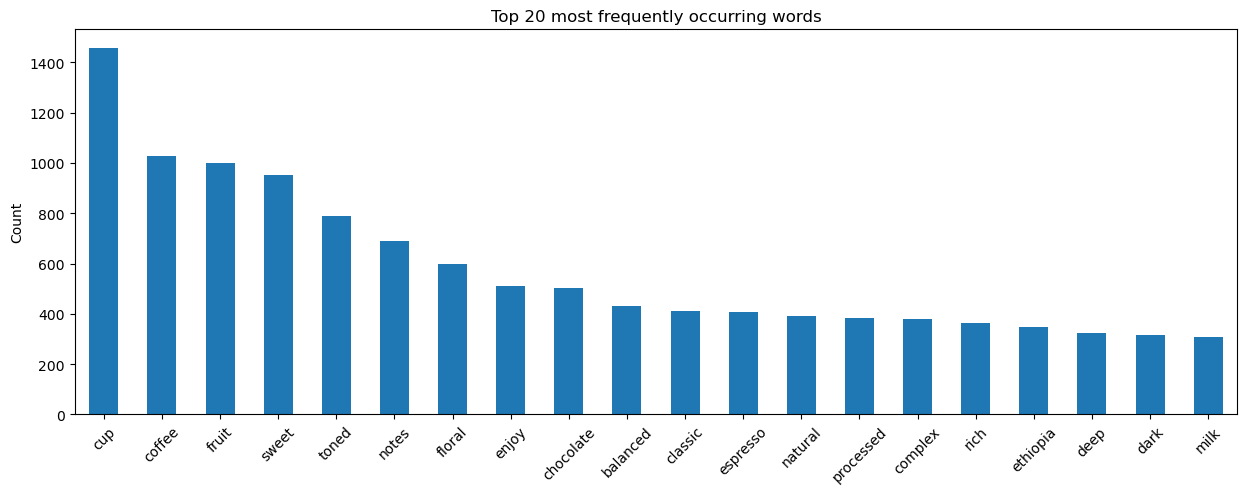

In [428]:
# 1. Instantiate 
bagofwords_p3 = CountVectorizer(stop_words='english', min_df=5, max_features=500, max_df=2000)

# 2. Fit 
bagofwords_p3.fit(X_remain["p3"])

# 3. Transform
p3_remain_transform = bagofwords_p3.transform(X_remain["p3"])
p3_val_transform = bagofwords_p3.transform(X_val["p3"])
p3_test_transform = bagofwords_p3.transform(X_test["p3"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": p3_remain_transform.toarray().sum(axis=0)},
    index=bagofwords_p3.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [429]:
bagofwords_p3.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['accessible',
 'acid',
 'acidity',
 'acidy',
 'adventurers',
 'aficionados',
 'africa',
 'alive',
 'america',
 'american',
 'anaerobic',
 'animated',
 'antigua',
 'appeal',
 'appealing',
 'appreciate',
 'arabica',
 'aroma',
 'aromatic',
 'aromatically',
 'aromatics',
 'assertive',
 'associated',
 'attractive',
 'authoritative',
 'authority',
 'avoid',
 'baking',
 'balance',
 'balanced',
 'ballast',
 'berry',
 'best',
 'better',
 'beverages',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blend',
 'blends',
 'blue',
 'bodied',
 'body',
 'bold',
 'bomb',
 'bourbon',
 'bracing',
 'brandy',
 'brazil',
 'breakfast',
 'brew',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brightness',
 'bring',
 'brisk',
 'briskly',
 'burned',
 'burundi',
 'buy',
 'cacao',
 'caffeine',
 'cappuccino',
 'caramel',
 'caramelly',
 'case',
 'cedar',
 'cedary',
 'celebrated',
 'centered',
 'central',
 'certified',
 'character',
 'characteristic',
 'cherry',
 'chocolate',
 'chocolaty',
 'c

This group seems to do pretty well with the basic cleaning, may also benefit from stemming.

In [430]:
len(bagofwords_p3.get_feature_names())

500

In [431]:
# 1. Instantiate the model
p3_model = LinearRegression()

# 2. Fit the model
p3_model.fit(p3_remain_transform, y_remain)

LinearRegression()

In [432]:
# 3. Scoring the training model
print(f'The R2 score for p3 CountVectorizor training data is: {p3_model.score(p3_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p3 CountVectorizor validation data is: {p3_model.score(p3_val_transform, y_val)}')

The R2 score for p3 CountVectorizor training data is: 0.5582512067987022
The R2 score for p3 CountVectorizor validation data is: 0.4263920734864891


### Text Transformation with TFIDF

Transforming `p1` paragraph with TFIDF and graphing:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


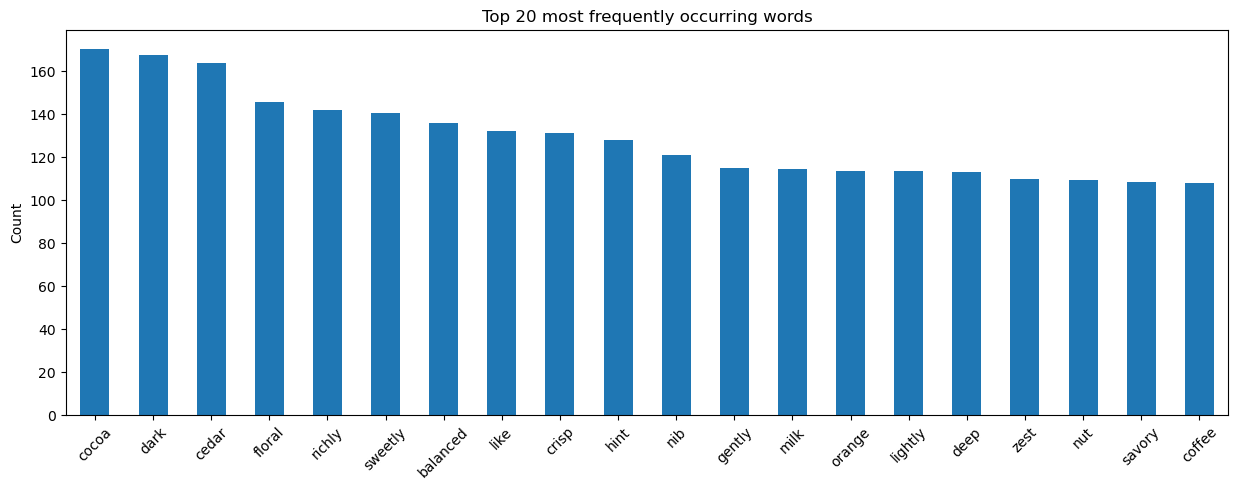

In [433]:
# 1. Instantiate 
tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p1.fit(X_remain["p1"])

# 3. Transform
tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
tp1_val_transform = tfidf_p1.transform(X_val["p1"])
tp1_test_transform = tfidf_p1.transform(X_test["p1"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp1_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p1.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [434]:
tfidf_p1.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['87',
 '88',
 '89',
 '90',
 '91',
 '92',
 'acid',
 'acidy',
 'admired',
 'aftertaste',
 'agave',
 'almond',
 'amber',
 'amplified',
 'anise',
 'apple',
 'apricot',
 'aromatic',
 'aromatics',
 'astringency',
 'astringent',
 'attractive',
 'authority',
 'b70',
 'backgrounded',
 'baker',
 'baking',
 'balance',
 'balanced',
 'banana',
 'barrel',
 'bean',
 'bergamot',
 'berries',
 'berry',
 'best',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blackberry',
 'blend',
 'blood',
 'blooming',
 'blooms',
 'blossom',
 'blueberry',
 'bodied',
 'body',
 'brandy',
 'brazil',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brisk',
 'brittle',
 'brown',
 'buoyant',
 'buoyantly',
 'burned',
 'butter',
 'butterscotch',
 'buttery',
 'cacao',
 'candied',
 'candy',
 'cane',
 'cappuccino',
 'capsule',
 'caramel',
 'caramelly',
 'carbon',
 'cardamom',
 'carob',
 'carried',
 'carries',
 'carry',
 'carrying',
 'cashew',
 'cedar',
 'cedary',
 'centered',
 'centers',
 'character',
 'cha

In [435]:
len(tfidf_p1.get_feature_names())

500

In [436]:
# 1. Instantiate the model
tp1_model = LinearRegression()

# 2. Fit the model
tp1_model.fit(tp1_remain_transform, y_remain)

LinearRegression()

In [437]:
# 3. Scoring the training model
print(f'The R2 score for p1 with TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p1 with TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

The R2 score for p1 with TFIDF training data is: 0.801760006154401
The R2 score for p1 with TFIDF validation data is: 0.7411141840021249


Transforming `p2` paragraph with TFIDF:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


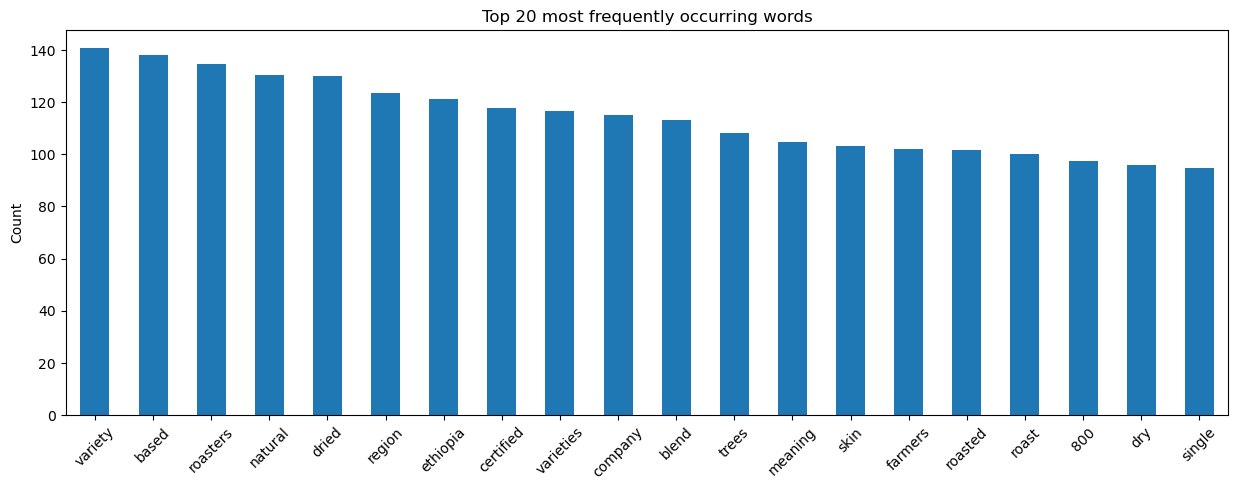

In [438]:
# 1. Instantiate 
tfidf_p2 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p2.fit(X_remain["p2"])

# 3. Transform
tp2_remain_transform = tfidf_p2.transform(X_remain["p2"])
tp2_val_transform = tfidf_p2.transform(X_val["p2"])
tp2_test_transform = tfidf_p2.transform(X_test["p2"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp2_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p2.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [439]:
tfidf_p2.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['0626',
 '100',
 '11',
 '1282',
 '1707',
 '1990',
 '2005',
 '2007',
 '2010',
 '2012',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '256',
 '30',
 '433',
 '454',
 '4627',
 '5282',
 '551',
 '608',
 '678',
 '763',
 '800',
 '858',
 '866',
 '877',
 '879',
 '886',
 '888',
 '916',
 'aa',
 'acidity',
 'active',
 'addition',
 'admired',
 'africa',
 'agricultural',
 'air',
 'allowed',
 'america',
 'american',
 'anaerobic',
 'angeles',
 'appear',
 'approach',
 'area',
 'aroma',
 'aromatic',
 'artisan',
 'asia',
 'associated',
 'auction',
 'available',
 'award',
 'awarded',
 'bag',
 'barista',
 'based',
 'batch',
 'batches',
 'bay',
 'bean',
 'beaned',
 'best',
 'better',
 'big',
 'bird',
 'birdrockcoffee',
 'black',
 'blend',
 'blends',
 'bold',
 'botanical',
 'bourbon',
 'boutique',
 'brand',
 'brazil',
 'brew',
 'brewing',
 'bring',
 'brothers',
 'burundi',
 'business',
 'cafe',
 'café',
 'california',
 'called',
 'capsule',
 'case',
 'catuai',
 'caturra',
 'celebrated',
 'central',
 'certifi

In [440]:
len(tfidf_p2.get_feature_names())

500

In [441]:
# 1. Instantiate the model
tp2_model = LinearRegression()

# 2. Fit the model
tp2_model.fit(tp2_remain_transform, y_remain)

LinearRegression()

In [442]:
# 3. Scoring the training model
print(f'The R2 score for p2 TFIDF training data is: {tp2_model.score(tp2_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p2 TFIDF validation data is: {tp2_model.score(tp2_val_transform, y_val)}')

The R2 score for p2 TFIDF training data is: 0.7203473229475446
The R2 score for p2 TFIDF validation data is: 0.571983200376174


Transforming `p3` with TFIDF:

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


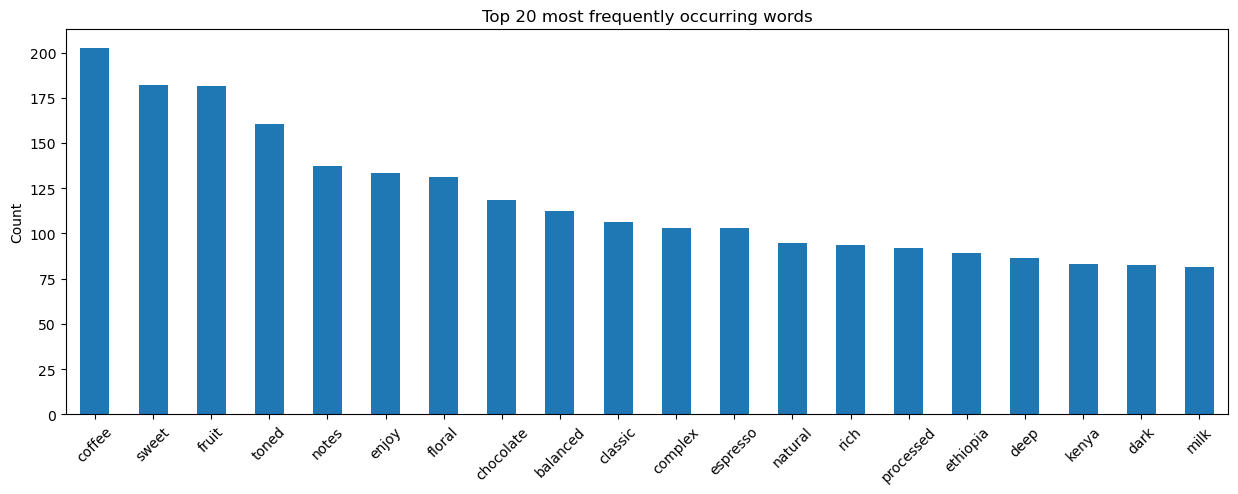

In [443]:
# 1. Instantiate 
tfidf_p3 = TfidfVectorizer(stop_words='english', min_df=5, max_df=1000, max_features=500)

# 2. Fit 
tfidf_p3.fit(X_remain["p3"])

# 3. Transform
tp3_remain_transform = tfidf_p3.transform(X_remain["p3"])
tp3_val_transform = tfidf_p3.transform(X_val["p3"])
tp3_test_transform = tfidf_p3.transform(X_test["p3"])

#the following looks at the 20 most popular words from paragraph 3

word_counts = pd.DataFrame(
    {"counts": tp3_remain_transform.toarray().sum(axis=0)},
    index=tfidf_p3.get_feature_names()
).sort_values("counts", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [444]:
tfidf_p3.get_feature_names()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['accessible',
 'acid',
 'acidity',
 'acidy',
 'adventurers',
 'aficionados',
 'africa',
 'alive',
 'america',
 'american',
 'anaerobic',
 'animated',
 'antigua',
 'appeal',
 'appealing',
 'appreciate',
 'arabica',
 'aroma',
 'aromatic',
 'aromatically',
 'aromatics',
 'assertive',
 'associated',
 'attractive',
 'authoritative',
 'authority',
 'avoid',
 'baking',
 'balance',
 'balanced',
 'ballast',
 'berry',
 'best',
 'better',
 'beverages',
 'big',
 'bit',
 'bitter',
 'bitterness',
 'bittersweet',
 'black',
 'blend',
 'blends',
 'blue',
 'bodied',
 'body',
 'bold',
 'bomb',
 'bourbon',
 'bracing',
 'brandy',
 'brazil',
 'breakfast',
 'brew',
 'brewed',
 'brewing',
 'bright',
 'brightly',
 'brightness',
 'bring',
 'brisk',
 'briskly',
 'burned',
 'burundi',
 'buy',
 'cacao',
 'caffeine',
 'cappuccino',
 'caramel',
 'caramelly',
 'case',
 'cedar',
 'cedary',
 'celebrated',
 'centered',
 'central',
 'certified',
 'character',
 'characteristic',
 'chocolate',
 'chocolaty',
 'choice',
 'c

In [445]:
len(tfidf_p3.get_feature_names())

500

In [446]:
# 1. Instantiate the model
tp3_model = LinearRegression()

# 2. Fit the model
tp3_model.fit(tp3_remain_transform, y_remain)

LinearRegression()

In [447]:
# 3. Scoring the training model
print(f'The R2 score for p3 TFIDF training data is: {tp3_model.score(tp3_remain_transform, y_remain)}')

# 3. Scoring the validation model
print(f'The R2 score for p3 TFIDF validation data is: {tp3_model.score(tp3_val_transform, y_val)}')

The R2 score for p3 TFIDF training data is: 0.5965025380040381
The R2 score for p3 TFIDF validation data is: 0.49353074848455647


### Exploring Different Parameters for Text Transformation

For now, we'll explore these a bit at a time. Time allowing, we can run more robust versions of these that account for how changing the parameters affects the performance of other parameters.

Exploring impact of changing min_df:

In [448]:
for i in range(1,30,2):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=i, max_features=500, max_df=2000)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'min_df: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

min_df: 1
The R2 score for p1 CountVectorizer training data is: 0.7849608201475559
The R2 score for p1 CountVectorizer validation data is: 0.7306083010549749
min_df: 3
The R2 score for p1 CountVectorizer training data is: 0.7845195941305492
The R2 score for p1 CountVectorizer validation data is: 0.7324155149753419
min_df: 5
The R2 score for p1 CountVectorizer training data is: 0.7844193816163427
The R2 score for p1 CountVectorizer validation data is: 0.7338312344946021
min_df: 7
The R2 score for p1 CountVectorizer training data is: 0.7844767063476692
The R2 score for p1 CountVectorizer validation data is: 0.7321937683385183
min_df: 9
The R2 score for p1 CountVectorizer training data is: 0.7848455287991923
The R2 score for p1 CountVectorizer validation data is: 0.7300226952440496
min_df: 11
The R2 score for p1 CountVectorizer training data is: 0.7841882143125594
The R2 score for p1 CountVectorizer validation data is: 0.731636253009903
min_df: 13
The R2 score for p1 CountVectorizer train

Experimenting with best max_feature range:

In [449]:
for i in range(100,1000,50):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=i, max_df=2000)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'max_features: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

max_features: 100
The R2 score for p1 CountVectorizer training data is: 0.5853535748810816
The R2 score for p1 CountVectorizer validation data is: 0.5931379547803348
max_features: 150
The R2 score for p1 CountVectorizer training data is: 0.6213898578017855
The R2 score for p1 CountVectorizer validation data is: 0.6197325905517572
max_features: 200
The R2 score for p1 CountVectorizer training data is: 0.6536811881892741
The R2 score for p1 CountVectorizer validation data is: 0.6452441163806364
max_features: 250
The R2 score for p1 CountVectorizer training data is: 0.670105471586677
The R2 score for p1 CountVectorizer validation data is: 0.6577896959735398
max_features: 300
The R2 score for p1 CountVectorizer training data is: 0.6985109803382252
The R2 score for p1 CountVectorizer validation data is: 0.6686361473225519
max_features: 350
The R2 score for p1 CountVectorizer training data is: 0.7382071484156348
The R2 score for p1 CountVectorizer validation data is: 0.7105983463402659
max_f

Modifying the number of `max_features` seems to matter a lot for validation data. 

In [450]:
for i in range(100,20000,1000):

    bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=i)

    bagofwords_p1.fit(X_remain["p1"])

    p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
    p1_val_transform = bagofwords_p1.transform(X_val["p1"])
    p1_test_transform = bagofwords_p1.transform(X_test["p1"])

    p1_model = LinearRegression()

    p1_model.fit(p1_remain_transform, y_remain)

    print(f'max_df: {i}')
    print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
    print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

max_df: 100
The R2 score for p1 CountVectorizer training data is: 0.6949997728512506
The R2 score for p1 CountVectorizer validation data is: 0.6400964590138822
max_df: 1100
The R2 score for p1 CountVectorizer training data is: 0.7751530405176393
The R2 score for p1 CountVectorizer validation data is: 0.7158705015393697
max_df: 2100
The R2 score for p1 CountVectorizer training data is: 0.7844767063476692
The R2 score for p1 CountVectorizer validation data is: 0.7321937683385183
max_df: 3100
The R2 score for p1 CountVectorizer training data is: 0.7901085030488569
The R2 score for p1 CountVectorizer validation data is: 0.7370499200177514
max_df: 4100
The R2 score for p1 CountVectorizer training data is: 0.7954457578015508
The R2 score for p1 CountVectorizer validation data is: 0.7494143317924434
max_df: 5100
The R2 score for p1 CountVectorizer training data is: 0.7954457578015508
The R2 score for p1 CountVectorizer validation data is: 0.7494143317924434
max_df: 6100
The R2 score for p1 Co

Max_df appears to best around 3100 and after that stops improving.

Testing with these parameters:

In [451]:
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=3100)

bagofwords_p1.fit(X_remain["p1"])

p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

p1_model = LinearRegression()

p1_model.fit(p1_remain_transform, y_remain)

print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')
print(f'The R2 score for p1 CountVectorizer validation data is: {p1_model.score(p1_val_transform, y_val)}')

The R2 score for p1 CountVectorizer training data is: 0.7901085030488569
The R2 score for p1 CountVectorizer validation data is: 0.7370499200177514


Doing similar thing with TFIDF:

In [452]:
for i in range(1,30,2):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=i, max_df=1000, max_features=500)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'min_df value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

min_df value: 1
The R2 score for p3 TFIDF training data is: 0.8018808001220123
The R2 score for p3 TFIDF validation data is: 0.7410179830115298
min_df value: 3
The R2 score for p3 TFIDF training data is: 0.801657126113539
The R2 score for p3 TFIDF validation data is: 0.7418233146930813
min_df value: 5
The R2 score for p3 TFIDF training data is: 0.801760006154401
The R2 score for p3 TFIDF validation data is: 0.7411141840021249
min_df value: 7
The R2 score for p3 TFIDF training data is: 0.8014335834479283
The R2 score for p3 TFIDF validation data is: 0.740554415668115
min_df value: 9
The R2 score for p3 TFIDF training data is: 0.8015538525344552
The R2 score for p3 TFIDF validation data is: 0.7410325198589318
min_df value: 11
The R2 score for p3 TFIDF training data is: 0.8014252038669638
The R2 score for p3 TFIDF validation data is: 0.7409169840108364
min_df value: 13
The R2 score for p3 TFIDF training data is: 0.7997312678630673
The R2 score for p3 TFIDF validation data is: 0.7428929568

This one also seems to do better with lower min_df value, peaking around 7 (although there's not a huge difference at lower scores).

Experimenting with max_features:

In [453]:
for i in range(1,1000,100):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=i, max_df=1000)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'max_features value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

max_features value: 1
The R2 score for p3 TFIDF training data is: 0.0016594318148461795
The R2 score for p3 TFIDF validation data is: 0.0055369003324216015
max_features value: 101
The R2 score for p3 TFIDF training data is: 0.6144268852251611
The R2 score for p3 TFIDF validation data is: 0.6075696495532765
max_features value: 201
The R2 score for p3 TFIDF training data is: 0.6823533867812924
The R2 score for p3 TFIDF validation data is: 0.6570514205297657
max_features value: 301
The R2 score for p3 TFIDF training data is: 0.7230185712909851
The R2 score for p3 TFIDF validation data is: 0.6838406451908287
max_features value: 401
The R2 score for p3 TFIDF training data is: 0.7821030071107289
The R2 score for p3 TFIDF validation data is: 0.7421531755096016
max_features value: 501
The R2 score for p3 TFIDF training data is: 0.8015086791529835
The R2 score for p3 TFIDF validation data is: 0.7408032484745166
max_features value: 601
The R2 score for p3 TFIDF training data is: 0.81900238724968

This one also seems to peak around 500.

Exploring max_df:

In [454]:
for i in range(1000,10000,500):
    
    tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=500, max_df=i)

    tfidf_p1.fit(X_remain["p1"])

    tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
    tp1_val_transform = tfidf_p1.transform(X_val["p1"])
    tp1_test_transform = tfidf_p1.transform(X_test["p1"])

    tp1_model = LinearRegression()

    tp1_model.fit(tp1_remain_transform, y_remain)

    print(f'max_df value: {i}')
    print(f'The R2 score for p3 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')
    print(f'The R2 score for p3 TFIDF validation data is: {tp1_model.score(tp1_val_transform, y_val)}')

max_df value: 1000
The R2 score for p3 TFIDF training data is: 0.8014335834479283
The R2 score for p3 TFIDF validation data is: 0.740554415668115
max_df value: 1500
The R2 score for p3 TFIDF training data is: 0.8127920197304129
The R2 score for p3 TFIDF validation data is: 0.7620373572650335
max_df value: 2000
The R2 score for p3 TFIDF training data is: 0.8146685975207608
The R2 score for p3 TFIDF validation data is: 0.7604433401212751
max_df value: 2500
The R2 score for p3 TFIDF training data is: 0.8171923091170072
The R2 score for p3 TFIDF validation data is: 0.7642682890233159
max_df value: 3000
The R2 score for p3 TFIDF training data is: 0.8181208441490506
The R2 score for p3 TFIDF validation data is: 0.7673494343569071
max_df value: 3500
The R2 score for p3 TFIDF training data is: 0.8190145890377654
The R2 score for p3 TFIDF validation data is: 0.7675262073183683
max_df value: 4000
The R2 score for p3 TFIDF training data is: 0.820560193295692
The R2 score for p3 TFIDF validation d

This one seems to peak around 4000.

### Word Embedding:

As a third potential approach to vectorizing our text, we'll employ word embedding with Gensim and lexvec.

In [455]:
#import word vectors to reference
model = gensim.models.KeyedVectors.load_word2vec_format(
    'lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False
)

In [456]:
#borrowing this code from representation learning module with BrainStation

def sentence2vec(text):
    
    """
    Embed a sentence by averaging the word vectors of the tokenized text. 
    Out-of-vocabulary words are replaced by the zero-vector.
    -----
    
    Input: text (string)
    Output: embedding vector (np.array)
    """
    tokenized = simple_preprocess(text)
    
    word_embeddings = [np.zeros(300)]
    
    for word in tokenized:
        # if the word is in the model then embed
        if word in model:
            vector = model[word]
        # add zeros for out-of-vocab words
        else:
            vector = np.zeros(300)
            
        word_embeddings.append(vector)
    
    # average the word vectors
    sentence_embedding = np.stack(word_embeddings).mean(axis=0)
     
    return sentence_embedding

### Embedding on p1:

In [457]:
#apply embedding to our 1st paragraph
X_remain_emb_p1 = X_remain['p1'].apply(sentence2vec)

X_remain_emb_p1.head()

0    [0.04017122201104131, -0.0687256950315916, 0.0...
1    [0.05132857880457059, -0.08209957885801007, -0...
2    [0.03006900035776198, -0.05376460149884224, 0....
3    [0.056471666583839134, -0.05562415346503258, 0...
4    [0.04179711815188913, -0.09886350058128729, 0....
Name: p1, dtype: object

In [458]:
#check shape
X_remain_emb_p1.shape

(4194,)

In [459]:
#turn into format we can use with predictive model
X_remain_emb_p1 = np.array(X_remain_emb_p1.tolist())

In [460]:
X_remain_emb_p1.shape

(4194, 300)

Fitting embed on p1:

In [461]:
emb_model_p1 = LinearRegression()
emb_model_p1.fit(X_remain_emb_p1, y_remain)

print(f'The R2 score for p1 embedded word training data is: {emb_model_p1.score(X_remain_emb_p1, y_remain)}')

The R2 score for p1 embedded word training data is: 0.7524858527226371


Transforming validation and test

In [462]:
X_val_emb_p1 = X_val['p1'].apply(sentence2vec)
X_test_emb_p1 = X_test['p1'].apply(sentence2vec)

In [463]:
X_val_emb_p1 = np.array(X_val_emb_p1.tolist())
X_test_emb_p1 = np.array(X_test_emb_p1.tolist())

Evauating the model with Linear Regression:

In [464]:
print(f'The R2 score for p1 embedded word validation data is: {emb_model_p1.score(X_val_emb_p1, y_val)}')
emb_val_lr_R2_p1 = emb_model_p1.score(X_val_emb_p1, y_val)
print(emb_val_lr_R2_p1)

The R2 score for p1 embedded word validation data is: 0.7300704554516655
0.7300704554516655


Fitting Random Forest on the model:

In [465]:
rf_emb_model_p1 = RandomForestRegressor()
rf_emb_model_p1.fit(X_remain_emb_p1, y_remain)

print(f'The R2 score for p1 embedded word training data is: {rf_emb_model_p1.score(X_remain_emb_p1, y_remain)}')

The R2 score for p1 embedded word training data is: 0.9564318068052231


Evaluating Random Forest model:

In [466]:
print(f'The R2 score for p1 embedded word validation data is: {rf_emb_model_p1.score(X_val_emb_p1, y_val)}')
emb_val_rf_r2 = rf_emb_model_p1.score(X_val_emb_p1, y_val)
print(emb_val_rf_r2)

The R2 score for p1 embedded word validation data is: 0.7007883683585937
0.7007883683585937


### Embedding on p2:

In [467]:
#apply embedding to our 1st paragraph
X_remain_emb_p2 = X_remain['p2'].apply(sentence2vec)

X_remain_emb_p2.head()

0    [0.023589030119844458, 0.003525651949034496, 0...
1    [0.024987128400243818, -0.017144642417718257, ...
2    [0.01481724209397247, -0.057650684859407574, 0...
3    [0.031376343087426255, 0.0007313720150185482, ...
4    [-0.004584299891333406, -0.0019251328466149667...
Name: p2, dtype: object

In [468]:
#turn into format we can use with predictive model
X_remain_emb_p2 = np.array(X_remain_emb_p2.tolist())

Fitting p2 with linear regression:

In [469]:
emb_model_p2 = LinearRegression()
emb_model_p2.fit(X_remain_emb_p2, y_remain)

print(f'The R2 score for p2 embedded word training data is: {emb_model_p2.score(X_remain_emb_p2, y_remain)}')

The R2 score for p2 embedded word training data is: 0.6351844415120553


Transforming test and validation data:

In [470]:
X_val_emb_p2 = X_val['p2'].apply(sentence2vec)
X_test_emb_p2 = X_test['p2'].apply(sentence2vec)

In [471]:
X_val_emb_p2 = np.array(X_val_emb_p2.tolist())
X_test_emb_p2 = np.array(X_test_emb_p2.tolist())

Evaluating linear regression model:

In [472]:
print(f'The R2 score for p1 embedded word validation data is: {emb_model_p2.score(X_val_emb_p2, y_val)}')
emb_val_lr_R2_p2 = emb_model_p2.score(X_val_emb_p2, y_val)
print(emb_val_lr_R2_p2)

The R2 score for p1 embedded word validation data is: 0.5350499187931407
0.5350499187931407


### Embedding on p3:

In [473]:
#apply embedding to our 1st paragraph
X_remain_emb_p3 = X_remain['p3'].apply(sentence2vec)

X_remain_emb_p3.head()

0    [0.009239582606824115, 0.01840674886868025, 0....
1    [0.030286631350846666, -0.07220905177956938, 0...
2    [0.04048899984696791, 0.02295347544852467, 0.0...
3    [0.04917112400289625, 0.014513750560581684, 0....
4    [-0.007726411417345791, -0.026726177071823794,...
Name: p3, dtype: object

In [474]:
#turn into format we can use with predictive model
X_remain_emb_p3 = np.array(X_remain_emb_p3.tolist())

In [475]:
emb_model_p3 = LinearRegression()
emb_model_p3.fit(X_remain_emb_p3, y_remain)

print(f'The R2 score for p3 embedded word training data is: {emb_model_p3.score(X_remain_emb_p3, y_remain)}')

The R2 score for p3 embedded word training data is: 0.5201730348991952


In [476]:
X_val_emb_p3 = X_val['p3'].apply(sentence2vec)
X_test_emb_p3 = X_test['p3'].apply(sentence2vec)

In [477]:
X_val_emb_p3 = np.array(X_val_emb_p3.tolist())
X_test_emb_p3 = np.array(X_test_emb_p3.tolist())

In [478]:
print(f'The R2 score for p3 embedded word validation data is: {emb_model_p3.score(X_val_emb_p3, y_val)}')
emb_val_lr_R2_p3 = emb_model_p3.score(X_val_emb_p3, y_val)
print(emb_val_lr_R2_p3)

The R2 score for p3 embedded word validation data is: 0.44240658622258944
0.44240658622258944


### Comparison of paragraphs

Across all 3 text transformation tecniques, we're by far getting the best results with paragraph 1: `p1`. Given each paragraph will add many columns to our model, for now we'll just move ahead using the paragraph 1 data. We may revisit this if time allows to try other approaches, such as combining the paragraphs before transforming them.

## Comparing Best Versions

**Evaluating with Linear Regression**
 
Below, we'll run some basic models to compare how effective the different transformation models are.

CountVectorizor() with linear regression:

In [479]:
bagofwords_p1 = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=3100)

bagofwords_p1.fit(X_remain["p1"])

p1_remain_transform = bagofwords_p1.transform(X_remain["p1"])
p1_val_transform = bagofwords_p1.transform(X_val["p1"])
p1_test_transform = bagofwords_p1.transform(X_test["p1"])

p1_model = LinearRegression()

p1_model.fit(p1_remain_transform, y_remain)

print(f'The R2 score for p1 CountVectorizer training data is: {p1_model.score(p1_remain_transform, y_remain)}')

CV_P1_LR_R2_val = p1_model.score(p1_val_transform, y_val)
print(f'CountVectorizer p1 LR model validation R2: {CV_P1_LR_R2_val}')

The R2 score for p1 CountVectorizer training data is: 0.7901085030488569
CountVectorizer p1 LR model validation R2: 0.7370499200177514


TfidfVectorizer() with linear regression:

In [480]:
tfidf_p1 = TfidfVectorizer(stop_words='english', min_df=7, max_features=500, max_df=4000)

tfidf_p1.fit(X_remain["p1"])

tp1_remain_transform = tfidf_p1.transform(X_remain["p1"])
tp1_val_transform = tfidf_p1.transform(X_val["p1"])
tp1_test_transform = tfidf_p1.transform(X_test["p1"])

tp1_model = LinearRegression()

tp1_model.fit(tp1_remain_transform, y_remain)

print(f'The R2 score for p1 TFIDF training data is: {tp1_model.score(tp1_remain_transform, y_remain)}')

TFIDF_P1_LR_R2_val = tp1_model.score(tp1_val_transform, y_val)
print(f'TFIDF p1 LR model validation R2: {TFIDF_P1_LR_R2_val}')

The R2 score for p1 TFIDF training data is: 0.820560193295692
TFIDF p1 LR model validation R2: 0.7695494969904821


**Evalutating with Random Forest** 

CountVectorizer() with Random Forest(): 

In [481]:
p1_rf_model = RandomForestRegressor()

p1_rf_model.fit(p1_remain_transform, y_remain)

print(f'The R2 RandomForest score for p1 CountVectorizer training data is: {p1_rf_model.score(p1_remain_transform, y_remain)}')

CV_P1_RF_R2_val = p1_rf_model.score(p1_val_transform, y_val)
print(f'CountVectorizer p1 Random Forest validation R2: {CV_P1_RF_R2_val}')

The R2 RandomForest score for p1 CountVectorizer training data is: 0.9548170075421767
CountVectorizer p1 Random Forest validation R2: 0.685910021527323


TFIDF Vectorizer() with RandomForest():

In [482]:
tp1_rf_model = RandomForestRegressor()

tp1_rf_model.fit(tp1_remain_transform, y_remain)

print(f'The R2 score for p1 TFIDF training data is: {tp1_rf_model.score(tp1_remain_transform, y_remain)}')
TFIDF_p1_RF_R2_val = tp1_rf_model.score(tp1_val_transform, y_val)
print(f'TFIDF p1 Random Forest validation R2: {TFIDF_p1_RF_R2_val}')

The R2 score for p1 TFIDF training data is: 0.9559177126635903
TFIDF p1 Random Forest validation R2: 0.7105023344629315


In [483]:
#Comparing the models

R2_dictionary = {'Word embed p1 LR model validation R2': emb_val_lr_R2, 'Word emb p1 Random Forest model validation R2': emb_val_rf_r2, 'CountVectorizer p1 LR model validation R2': CV_P1_LR_R2_val, 'TFIDF p1 LR model validation R2': TFIDF_P1_LR_R2_val, 'CountVectorizer p1 Random Forest validation R2': CV_P1_RF_R2_val, 'TFIDF p1 Random Forest validation R2': TFIDF_p1_RF_R2_val}

In [484]:
#sorting scores
R2_values_sorted = dict(sorted(R2_dictionary.items(), key = operator.itemgetter(1), reverse=True))

In [485]:
R2_values_sorted 

{'TFIDF p1 LR model validation R2': 0.7695494969904821,
 'CountVectorizer p1 LR model validation R2': 0.7370499200177514,
 'TFIDF p1 Random Forest validation R2': 0.7105023344629315,
 'Word emb p1 Random Forest model validation R2': 0.7007883683585937,
 'Word embed p1 LR model validation R2': 0.6976499367957549,
 'CountVectorizer p1 Random Forest validation R2': 0.685910021527323}

In general, the linear regression model works better on this data than Random Forest.

When evaluating with linear regression, TFIDF performs best, followed by CountVectorizer and then Word Embedding. In contrast, when evaluating with Random Forest, Word Embedding performs best, then CountVectorizer, and then TFIDF.

To move forward, we'll create 3 versions of the transformed text data. We'll combined this with our numeric values. To keep the versions straight, the following abbreviations will be used when referring to the data type:

- CountVectorizer: CV
- TFIDF: TFIDF
- Word Embedding: WE

## Creating the Updated Datasets

Using the insights from above, we'll fit and transform the `p1` data. Redoing this process from the start to make sure we are using the correct data. 

### CountVectorizer()
Staring with CountVectorizer():

In [486]:
CV_final_bag = CountVectorizer(stop_words='english', min_df=7, max_features=500, max_df=3100)

CV_final_bag.fit(X_remain["p1"])

p1_remain_transform = CV_final_bag.transform(X_remain["p1"])
p1_val_transform = CV_final_bag.transform(X_val["p1"])
p1_test_transform = CV_final_bag.transform(X_test["p1"])

In [487]:
#verifying transformed data currently gives us sparse matrices (as expected)
#can also see that they each have 500 columns

p1_remain_transform

<4194x500 sparse matrix of type '<class 'numpy.int64'>'
	with 89823 stored elements in Compressed Sparse Row format>

In [488]:
p1_val_transform 

<1049x500 sparse matrix of type '<class 'numpy.int64'>'
	with 22571 stored elements in Compressed Sparse Row format>

In [489]:
p1_test_transform

<1311x500 sparse matrix of type '<class 'numpy.int64'>'
	with 28002 stored elements in Compressed Sparse Row format>

Transform sparse matrices into dataframes:

In [490]:
#transforming the 'remain' sparse matrix into a dataframe
cv_remain_df = pd.DataFrame.sparse.from_spmatrix(p1_remain_transform, columns=CV_final_bag.get_feature_names())
cv_remain_df.head()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,87,88,89,90,91,92,acid,acidity,acidy,admired,...,white,wild,willem,wine,winy,wisteria,wood,woody,zest,zesty
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [491]:
X_remain

,coffee_name,roaster_name,month,year,bean_agtron,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,p1,p2,p3
0,Guatemala Covadonga Micro-Lot,Klatch Coffee,9,2013,53,69,9,9,8,9,8,34.053691,-118.242766,15.585555,-90.345759,"Smooth, layered complexity. Delicate floral n...",Produced on Finca Covadonga by farmer Roberto...,A fine exemplar of the sweet lucidity of the ...
1,Nano Genji Agaro Gera,Temple Coffee Roasters,6,2020,52,68,9,9,9,9,8,38.581061,-121.493895,10.211670,38.652120,"Deep-toned, fruit-centered, richly aromatic. ...",Ethiopia coffees like this one are produced l...,"A deeply fruit-toned washed Ethiopia cup, bro..."
2,Sumatran Reserve (K-Cup),Green Mountain Coffee,12,2005,54,71,6,6,6,6,6,44.337125,-72.755497,1.636405,99.691038,(As brewed in a Keurig B60 single-serve brewi...,Keurig brewing devices were among the first s...,Lovers of Sumatras who care more about the ma...
3,Port of Call,Island Joe's Coffee,6,2007,39,46,8,7,7,7,7,24.562557,-81.772437,-2.483383,117.890285,"Very sweet-toned aroma with a muted, pungent ...",Joe Wells started his small-batch roasting bu...,Those who prefer a calm port of call.
4,Yemen Mocha Harazi,Dragonfly Coffee Roasters,7,2021,62,78,9,8,9,9,8,36.030113,-114.982619,16.347124,47.891527,"Crisply spice-toned. Molasses, dried cherry, ...",Sourced from producer groups across Yemen’s S...,A sweetly spice-toned Yemen cup with underton...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189,El Obraje Geisha,Dragonfly Coffee Roasters,5,2018,52,78,9,9,9,9,9,40.015416,-105.270241,4.099917,-72.908813,"Nuanced, multi-layered, richly sweet. Lavende...",Produced from trees of the rare Ethiopia-deri...,An exciting Colombia Gesha cup that covers al...
4190,Arabica Express Kenya AA,Podhead,12,2005,54,71,6,7,7,7,7,41.450102,-71.449500,1.441968,38.431398,(As brewed in a Melitta One:One single-serve ...,Despite declining production and unrest in co...,A Kenya seen stale and from afar.
4191,Papua New Guinea Sigri Estate Medium Roast,Raggiana Coffee,6,2021,52,70,9,8,8,9,8,36.162277,-86.774298,-5.681607,144.248908,"Sweet, richly nut-toned. Cashew butter, cocoa...",Produced at Sigri Estate from trees of the Ty...,"An understated, balanced PNG cup with pretty ..."
4192,Breakfast Blend,American Favorites,3,2008,54,65,8,8,8,8,8,45.520247,-122.674194,10.198811,-12.161417,"Big, juicy, lushly tart coffee. Distinct flow...",American Favorites is a collaboration between...,A versatile breakfast cup both robustly acidy...


In [492]:
#transforming the 'validation' sparse matrix into a dataframe
cv_val_df = pd.DataFrame.sparse.from_spmatrix(p1_val_transform, columns=CV_final_bag.get_feature_names())
cv_val_df.head()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,87,88,89,90,91,92,acid,acidity,acidy,admired,...,white,wild,willem,wine,winy,wisteria,wood,woody,zest,zesty
0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [493]:
#transforming the 'test' sparse matrix into a dataframe
cv_test_df = pd.DataFrame.sparse.from_spmatrix(p1_test_transform, columns=CV_final_bag.get_feature_names())
cv_test_df.head()

/Users/katemondal/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,87,88,89,90,91,92,acid,acidity,acidy,admired,...,white,wild,willem,wine,winy,wisteria,wood,woody,zest,zesty
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Checking shape of new matrices compared to original remain, validate, test splits. Goal: verify that they have the same number of rows so taht we can recombine our data.

Both remain dfs have 4194 rows:

In [494]:
cv_remain_df.shape

(4194, 500)

In [495]:
X_remain.shape

(4194, 18)

Both validation dfs have 1049 rows:

In [496]:
cv_val_df.shape

(1049, 500)

In [497]:
X_val.shape

(1049, 18)

Both test dfs have 1311 rows:

In [498]:
cv_test_df.shape

(1311, 500)

In [499]:
X_test.shape

(1311, 18)

Combing the CountVectorized dataframes:

In [502]:
#combining "remain" dataframes
cv_remain_combo_df = pd.concat([cv_remain_df, X_remain], axis = 1)
cv_remain_combo_df.sample(5)

,87,88,89,90,91,92,acid,acidity,acidy,admired,...,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon,p1,p2,p3
2587,0,0,0,0,0,0,0,1,0,0,...,8,9,8,51.046095,-114.065465,8.559559,-81.130843,"Intense, complex floral notes (lavender, lily...",This is a lot of Esmeralda Gesha (also spelle...,Super aficionados on a budget. A (believe it ...
318,0,0,0,0,0,0,0,1,0,0,...,8,9,8,37.336166,-121.890591,10.211670,38.652120,"A ready-to-drink black coffee, tested cold. B...",The coffee tied for the second-highest rating...,What would obviously be a friendly and inviti...
2252,0,0,0,0,0,0,0,0,0,0,...,8,7,7,42.331551,-83.046640,-2.483383,117.890285,A coffee whose uncompromisingly earthy charac...,An eight-year aged coffee originating in the ...,Lovers of earthy Sumatras who want to up the ...
2297,0,0,0,0,0,0,0,1,0,0,...,8,9,9,38.581061,-121.493895,-2.483383,117.890285,"Deep, complex, pungent. Sweetly tart grapefru...",Coffees from the northern part of the Indones...,A superb Sumatra; a wonderful introduction to...
1919,0,0,0,0,0,0,0,1,0,0,...,8,9,8,25.045275,121.507800,15.585555,-90.345759,"Sweetly and deeply floral. Flowers (lilac, la...",From trees of the heirloom Bourbon and respec...,Those who value vivacity in a cup both sweetl...


In [501]:
#checking we get the shape we expect: 4194 x 518
cv_remain_combo_df.shape

(4194, 518)

In [503]:
#getting rid of columns no longer needed now that text is transformed
cv_remain_combo_df.drop(['p1', 'p2', 'p3'], axis=1, inplace=True)
cv_remain_combo_df

,87,88,89,90,91,92,acid,acidity,acidy,admired,...,ground_agtron,aroma,acidity,body,flavor,aftertaste,roaster_lat,roaster_lon,origin_lat,origin_lon
0,0,0,0,0,0,0,0,1,0,0,...,69,9,9,8,9,8,34.053691,-118.242766,15.585555,-90.345759
1,0,0,0,0,0,0,0,1,0,0,...,68,9,9,9,9,8,38.581061,-121.493895,10.211670,38.652120
2,0,0,0,0,0,0,0,0,0,0,...,71,6,6,6,6,6,44.337125,-72.755497,1.636405,99.691038
3,0,0,0,0,0,0,0,0,0,0,...,46,8,7,7,7,7,24.562557,-81.772437,-2.483383,117.890285
4,0,0,0,0,0,0,0,1,0,0,...,78,9,8,9,9,8,36.030113,-114.982619,16.347124,47.891527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189,0,0,0,0,0,0,0,1,0,0,...,78,9,9,9,9,9,40.015416,-105.270241,4.099917,-72.908813
4190,0,0,0,0,0,0,0,0,1,0,...,71,6,7,7,7,7,41.450102,-71.449500,1.441968,38.431398
4191,0,0,0,0,0,0,0,1,0,0,...,70,9,8,8,9,8,36.162277,-86.774298,-5.681607,144.248908
4192,0,0,0,0,0,0,0,0,0,0,...,65,8,8,8,8,8,45.520247,-122.674194,10.198811,-12.161417


In [506]:
cv_remain_combo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4194 entries, 0 to 4193
Columns: 515 entries, 87 to origin_lon
dtypes: Sparse[int64, 0](500), float64(4), int64(9), object(2)
memory usage: 1.5+ MB


Below, doing some cross-references of coffee names, roaster names, and scores by coffeereview.com to verify transformations preserved indices properly and allow us to match up X and y as expected using the index. By Googling the coffee name, roaster name, and checking the score, we can verify these are matching up correctly.

In [519]:
cv_remain_combo_df[['coffee_name','roaster_name']]

,coffee_name,roaster_name
0,Guatemala Covadonga Micro-Lot,Klatch Coffee
1,Nano Genji Agaro Gera,Temple Coffee Roasters
2,Sumatran Reserve (K-Cup),Green Mountain Coffee
3,Port of Call,Island Joe's Coffee
4,Yemen Mocha Harazi,Dragonfly Coffee Roasters
...,...,...
4189,El Obraje Geisha,Dragonfly Coffee Roasters
4190,Arabica Express Kenya AA,Podhead
4191,Papua New Guinea Sigri Estate Medium Roast,Raggiana Coffee
4192,Breakfast Blend,American Favorites


In [518]:
y_remain

0       93
1       94
2       81
3       87
4       93
        ..
4189    95
4190    84
4191    92
4192    92
4193    93
Name: overall_score, Length: 4194, dtype: int64

In [520]:
#save CountVectorized + original other columns for easy reference
cv_remain_combo_df.to_csv('cv_remain_combo_df.csv', index=False)

In [522]:
test_cv = pd.read_csv('cv_remain_combo_df.csv')
test_cv

,87,88,89,90,91,92,acid,acidity,acidy,admired,...,ground_agtron,aroma,acidity.1,body.1,flavor.1,aftertaste.1,roaster_lat,roaster_lon,origin_lat,origin_lon
0,0,0,0,0,0,0,0,1,0,0,...,69,9,9,8,9,8,34.053691,-118.242766,15.585555,-90.345759
1,0,0,0,0,0,0,0,1,0,0,...,68,9,9,9,9,8,38.581061,-121.493895,10.211670,38.652120
2,0,0,0,0,0,0,0,0,0,0,...,71,6,6,6,6,6,44.337125,-72.755497,1.636405,99.691038
3,0,0,0,0,0,0,0,0,0,0,...,46,8,7,7,7,7,24.562557,-81.772437,-2.483383,117.890285
4,0,0,0,0,0,0,0,1,0,0,...,78,9,8,9,9,8,36.030113,-114.982619,16.347124,47.891527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189,0,0,0,0,0,0,0,1,0,0,...,78,9,9,9,9,9,40.015416,-105.270241,4.099917,-72.908813
4190,0,0,0,0,0,0,0,0,1,0,...,71,6,7,7,7,7,41.450102,-71.449500,1.441968,38.431398
4191,0,0,0,0,0,0,0,1,0,0,...,70,9,8,8,9,8,36.162277,-86.774298,-5.681607,144.248908
4192,0,0,0,0,0,0,0,0,0,0,...,65,8,8,8,8,8,45.520247,-122.674194,10.198811,-12.161417
